### 1. Load Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = './stock_data/FB.csv'
data = pd.read_csv(filepath, index_col=0)
data = data.sort_values('Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


In [3]:
data.shape

(252, 6)

In [4]:
# Time Series
ts = data['Close']
ts.info()
ts.head(10)

<class 'pandas.core.series.Series'>
Index: 252 entries, 2018-05-23 to 2019-05-23
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
252 non-null    float64
dtypes: float64(1)
memory usage: 3.9+ KB


Date
2018-05-23    186.899994
2018-05-24    185.929993
2018-05-25    184.919998
2018-05-29    185.740005
2018-05-30    187.669998
2018-05-31    191.779999
2018-06-01    193.990005
2018-06-04    193.279999
2018-06-05    192.940002
2018-06-06    191.339996
Name: Close, dtype: float64

### 2. Visualisation

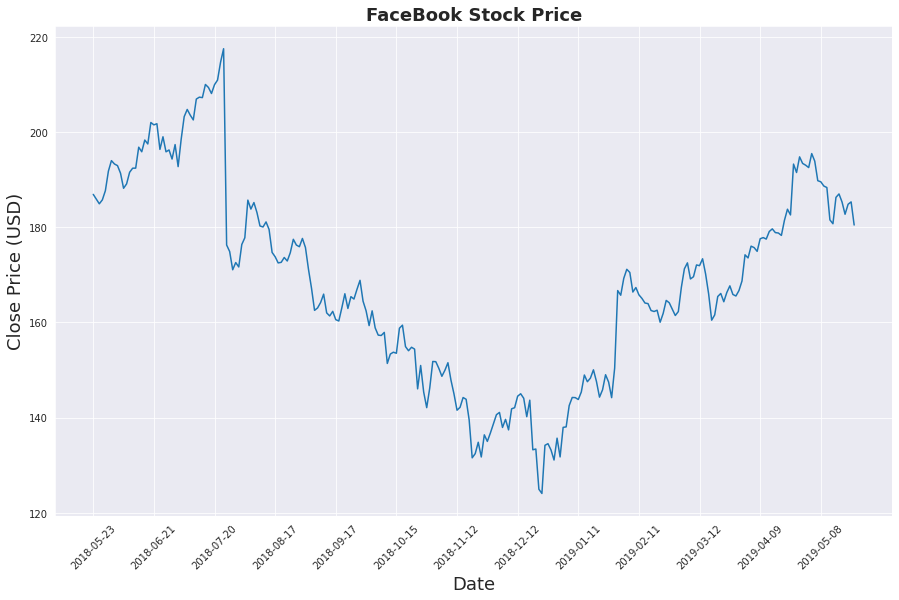

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(ts)
plt.xticks(range(0, data.shape[0], 20), data.index[::20], rotation=45)
plt.title("FaceBook Stock Price", fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.show()

### 3. Function for testing stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(range(0,ts.shape[0],20), data.index[::20], rotation=45)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['adf','pvalue','usedlag', 'nobs'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

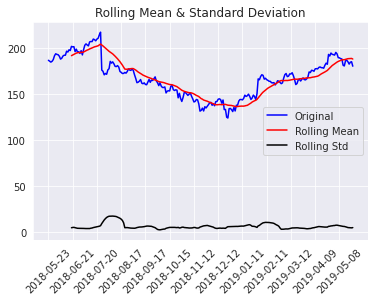

Results of Dickey-Fuller Test:
adf                      -1.629497
pvalue                    0.467754
usedlag                   0.000000
nobs                    251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


In [7]:
test_stationarity(ts)

##### adf > Critical Value (1%) 不能拒绝原假设，即原序列存在单位根，那么先一阶差分再进行ADF检验。

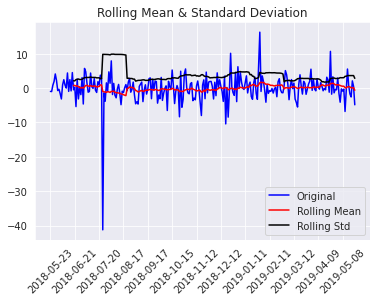

Results of Dickey-Fuller Test:
adf                    -1.604511e+01
pvalue                  5.856371e-29
usedlag                 0.000000e+00
nobs                    2.500000e+02
Critical Value (1%)    -3.456781e+00
Critical Value (5%)    -2.873172e+00
Critical Value (10%)   -2.572969e+00
dtype: float64


In [8]:
ts1= ts.diff().dropna() # 一阶差分
test_stationarity(ts1) # ADF检验

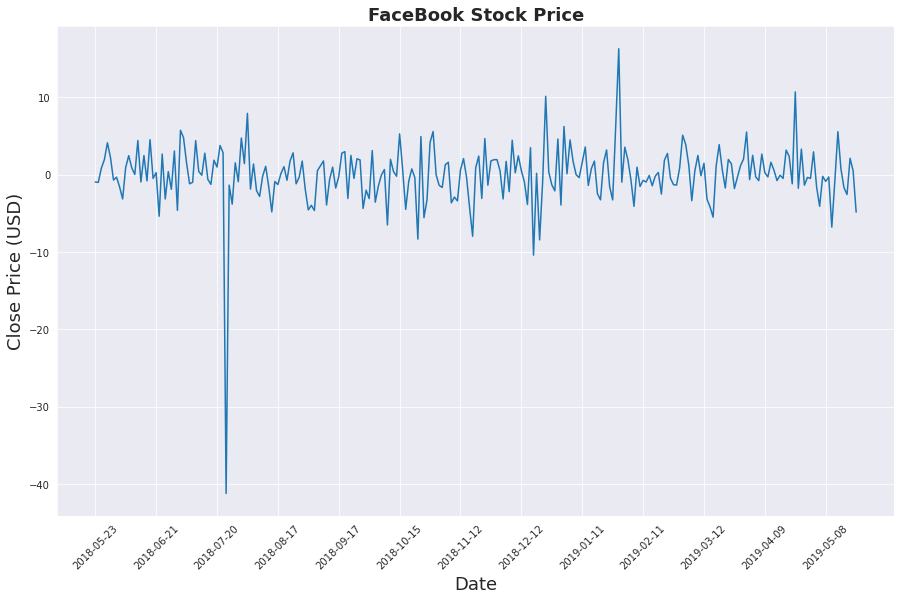

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(ts1)
plt.xticks(range(0, data.shape[0],20), data.index[::20], rotation=45)
plt.title("FaceBook Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

### 4. Feature Engineering

In [10]:
price = data[['Close']].diff().dropna()
price.head()

,Close
Date,
2018-05-24,-0.970001
2018-05-25,-1.009995
2018-05-29,0.820007
2018-05-30,1.929993
2018-05-31,4.110001


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [12]:
price.shape

(251, 1)

### 5. Dataset

In [13]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, 0:1]
    
    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, 0:1]
    
    return [x_train, y_train, x_test, y_test]

In [14]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (185, 19, 1)
y_train.shape =  (185, 1)
x_test.shape =  (46, 19, 1)
y_test.shape =  (46, 1)


### 6. Model Construction

In [15]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [16]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 60

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [18]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

### 7. Model Training

In [19]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.1974172294139862
Epoch  1 MSE:  0.09198656678199768
Epoch  2 MSE:  0.02732105739414692
Epoch  3 MSE:  0.09978345036506653
Epoch  4 MSE:  0.03944268450140953
Epoch  5 MSE:  0.024386774748563766
Epoch  6 MSE:  0.03145742788910866
Epoch  7 MSE:  0.03901011869311333
Epoch  8 MSE:  0.04197462275624275
Epoch  9 MSE:  0.04081453010439873
Epoch  10 MSE:  0.0370858870446682
Epoch  11 MSE:  0.0323466882109642
Epoch  12 MSE:  0.027969015762209892
Epoch  13 MSE:  0.0250689797103405
Epoch  14 MSE:  0.024316707625985146
Epoch  15 MSE:  0.025604350492358208
Epoch  16 MSE:  0.0277752336114645
Epoch  17 MSE:  0.029252856969833374
Epoch  18 MSE:  0.029234087094664574
Epoch  19 MSE:  0.027999522164463997
Epoch  20 MSE:  0.026366805657744408
Epoch  21 MSE:  0.025049511343240738
Epoch  22 MSE:  0.024374479427933693
Epoch  23 MSE:  0.024319136515259743
Epoch  24 MSE:  0.02466914989054203
Epoch  25 MSE:  0.025163348764181137
Epoch  26 MSE:  0.02558424137532711
Epoch  27 MSE:  0.0257987417280

### 8. Results Visualization

In [20]:
y_train_pred_inv = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_lstm_inv = scaler.inverse_transform(y_train_lstm.detach().numpy())

In [21]:
y_label = np.expand_dims(data['Close'], 1)
y_label.shape

(252, 1)

In [22]:
# Note: start from lookback loc or lookback-1 loc?
y_train_pred_inv += y_label[20:205]
y_train_lstm_inv += y_label[20:205]

In [23]:
predict = pd.DataFrame(y_train_pred_inv)
original = pd.DataFrame(y_train_lstm_inv)

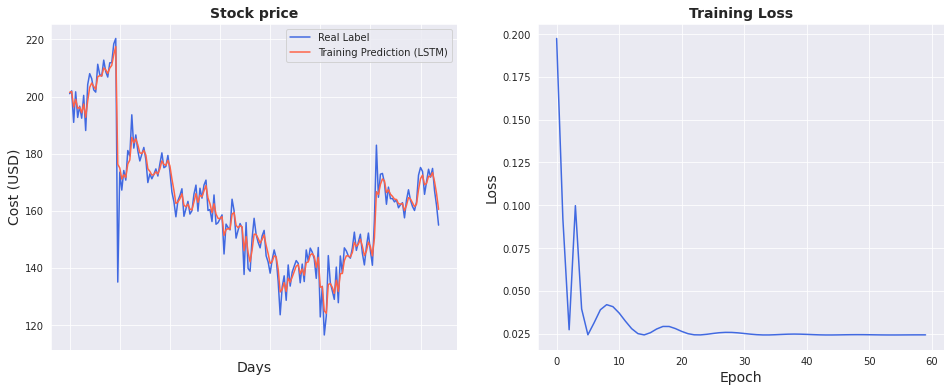

In [24]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Real Label", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)